Diperoleh dari https://keras.io/examples/vision/captcha_ocr/

Mengimpor ... selesai!
Menyiapkan data ... selesai!
Banyak data train:  3000
Banyak data validasi:  1000
Memuat visualisasi ...


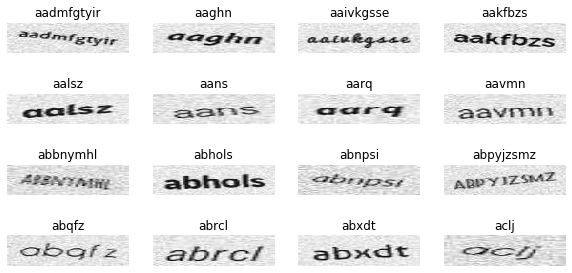

Membangun model ... selesai!
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 16, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   18496       pool1[0][0]                      
__________________________________________________________

In [1]:
### Impor
print("Mengimpor ... ", end = "")

import os
import numpy as np
import matplotlib.pyplot as plt
import editdistance
import string

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline

print("selesai!")

### Menyiapkan data
print("Menyiapkan data ... ", end = "")

# Konstanta
CHARACTERS = set(string.ascii_lowercase) # + " "
MAX_LENGTH = 10

# Path ke direktori data yang digunakan
train_data_dir = Path("./test/train/")
valid_data_dir = Path("./test/val/")

# Muat semua citra (format JPG)
train_images = sorted(list(map(str, list(train_data_dir.glob("*.jpg")))))
train_labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in train_images]

valid_images = sorted(list(map(str, list(valid_data_dir.glob("*.jpg")))))
valid_labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in valid_images]

# Ukuran batch untuk training dan validasi
batch_size = 1 # Untuk SGD

# Dimensi citra yang diinginkan
img_width = 128
img_height = 32

# Faktor downsampled: untuk dua blok konvolusi yang masing-masing terdiri dari lapisan pool
# dan ingin di-downsample dengan faktor 2. Jadi, 2 x 2 = 4.
downsample_factor = 4

# Map character -> integer

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(CHARACTERS), mask_token=None
)

# Map integer -> characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Inisialisasi x dan y
x_train = np.array(train_images)
x_valid = np.array(valid_images)
y_train = np.array(train_labels)
y_valid = np.array(valid_labels)

def encode_single_sample(img_path, label):
    # 1. Baca citra
    img = tf.io.read_file(img_path)
    # 2. Dekode and konversi ke grayscale (untuk JPG)
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Konversi ke float32 dalam range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Sesuaikan dimensi yang diinginkan
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpos agar dimensi waktu berkorespondensi dengan lebar (horizontal)
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map karakter dalam label ke angka
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Hasilkan dict: model mengharapkan input seperti ini
    return {"image": img, "label": label}

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print("selesai!")
print("Banyak data train: ", len(train_images))
print("Banyak data validasi: ", len(valid_images))

### Visualisasi data train
print("Memuat visualisasi ...")
_, ax = plt.subplots(4, 4, figsize=(10, 5))
i = 0
for batch in train_dataset.take(16):
    images = batch["image"]
    labels = batch["label"]
    img = (images[0] * 255).numpy().astype("uint8")
    label = tf.strings.reduce_join(num_to_char(labels[0])).numpy().decode("utf-8")
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
    i += 1
plt.show()

### Pembangunan model
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Blok conv pertama
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Blok conv kedua
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    
    return model


# Get the model
print("Membangun model ... ", end = "")
model = build_model()
print("selesai!")
model.summary()

In [4]:
### Memuat weight
print("Memuat weight yang tersimpan ... ", end = "")
model.load_weights("./checkpoints/text-recognizer")
print("selesai!")

Memuat weight yang tersimpan ... selesai!


In [ ]:
### Pelatihan
print("Memulai latihan ...")
epochs = 5
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)
print("Latihan selesai! Semoga semakin pintar. :D")

print("Menyimpan weight ... ", end = "")
model.save_weights("./checkpoints/text-recognizer")
print("selesai!")

Memulai latihan ...
Epoch 1/5
1491/3000 [=============>................] - ETA: 1:31 - loss: 5.6302

Memuat hasil ...


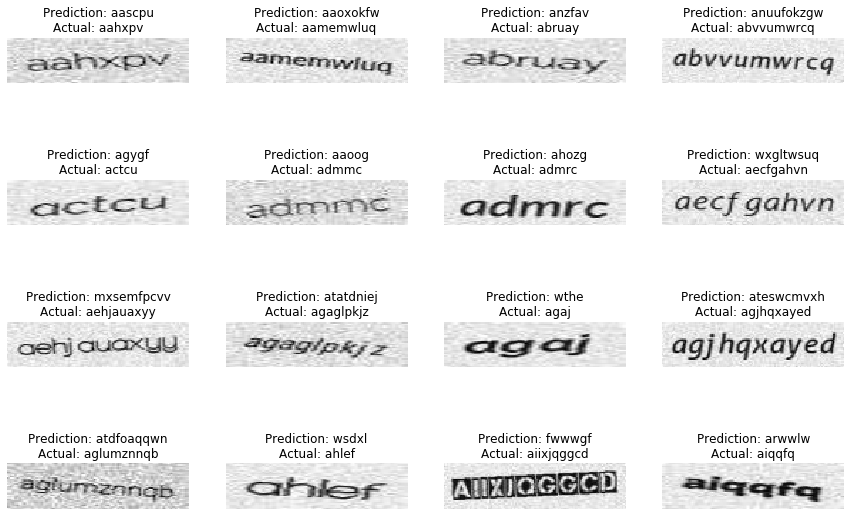

Mean Levensthein Distance: 6.4830	Score: 0/1000 (0.00%)
Hasil selesai. :)


In [2]:
### Hasil
print("Memuat hasil ...")
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :MAX_LENGTH
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
i = 0
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in validation_dataset.take(16):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_text = decode_batch_predictions(preds)[0].replace("[UNK]", "")

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    orig_text = orig_texts[0]

    img = (batch_images[0, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T
    title = f"Prediction: {pred_text}\nActual: {orig_text}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
    """
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    """
    i += 1
    
plt.show()

# Mean Levensthein Distance
sum_of_levensthein_distance = 0
correct = 0
i = 0
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_text = decode_batch_predictions(preds)[0].replace("[UNK]", "")

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    orig_text = orig_texts[0]

    lev_distance = editdistance.eval(pred_text, orig_text)
    sum_of_levensthein_distance += lev_distance
    if lev_distance == 0:
        correct += 1
    i += 1
    print("Mean Levensthein Distance: %.4f\tScore: %d/%d (%.2f%%)\r" % (sum_of_levensthein_distance / i, correct, i, 100 * correct / i), end = "")
    
print("\nHasil selesai. :)")